# Overview of Java Artifacts with Neo4j
<br>  

### References
- [jqassistant](https://jqassistant.org)
- [py2neo](https://py2neo.org/2021.1/)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plot
from py2neo import Graph

In [2]:
# Please set the environment variable "NEO4J_INITIAL_PASSWORD" in your shell 
# before starting jupyter notebook to provide the password for the user "neo4j". 
# It is not recommended to hardcode the password into jupyter notebook for security reasons.
graph = Graph("bolt://localhost:7687", auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD")))

In [3]:
def get_cypher_query_from_file(filename):
    with open(filename) as file:
        return ' '.join(file.readlines())

In [4]:
def query_cypher_to_data_frame(filename):
    return graph.run(get_cypher_query_from_file(filename)).to_data_frame()

In [5]:
#The following cell uses the build-in %html "magic" to override the CSS style for tables to a much smaller size.
#This is especially needed for PDF export of tables with multiple columns.

In [6]:
%%html
<style>
/* CSS style for smaller dataframe tables. */
.dataframe th {
    font-size: 8px;
}
.dataframe td {
    font-size: 8px;
}
</style>

In [7]:
# Main Colormap
main_color_map = 'nipy_spectral'

## Artifacts

### Table 1 - Types per artifact

In [8]:
types_per_artifact = query_cypher_to_data_frame("../cypher/Overview/Number_of_types_per_artifact.cypher")
types_per_artifact

,artifactName,languageElement,numberOfTypes
0,axon-disruptor-4.7.5,Class,22
1,axon-eventsourcing-4.7.5,Class,96
2,axon-eventsourcing-4.7.5,Interface,31
3,axon-eventsourcing-4.7.5,Annotation,1
4,axon-eventsourcing-4.7.5,Enum,2
5,axon-test-4.7.5,Class,69
6,axon-test-4.7.5,Interface,16
7,axon-messaging-4.7.5,Class,541
8,axon-messaging-4.7.5,Enum,19
9,axon-messaging-4.7.5,Interface,143


### Table 2 - Types per artifact (grouped)

In [9]:
# Pivot the DataFrame to 
# - group by the first column (artifactName) as new index
# - convert the values in the second column (typeLabel) 
# - into columns with the value of the third column (numberOfTypes).
types_per_artifact_grouped = types_per_artifact.pivot(index='artifactName', columns='languageElement', values='numberOfTypes')

# Fill missing values with zero
types_per_artifact_grouped.fillna(0, inplace=True)

# Calculate the sum of values for each row
types_per_artifact_grouped['Total'] = types_per_artifact_grouped.sum(axis=1)

# Sort the DataFrame by the sum of values
types_per_artifact_grouped.sort_values(by='Total', ascending=False, inplace=True)

# Remove the 'Total' column
types_per_artifact_grouped.drop('Total', axis=1, inplace=True)

# Sort the order of the columns by their sum
column_sum = types_per_artifact_grouped.sum()
types_per_artifact_grouped = types_per_artifact_grouped[column_sum.sort_values(ascending=False).index[:]]

# Convert to integer
types_per_artifact_grouped.astype(int)

languageElement,Class,Interface,Annotation,Enum
artifactName,,,,
axon-messaging-4.7.5,541,143,26,19
axon-modelling-4.7.5,108,26,12,3
axon-eventsourcing-4.7.5,96,31,1,2
axon-test-4.7.5,69,16,0,0
axon-configuration-4.7.5,22,15,1,1
axon-disruptor-4.7.5,22,0,0,0


<Figure size 640x480 with 0 Axes>

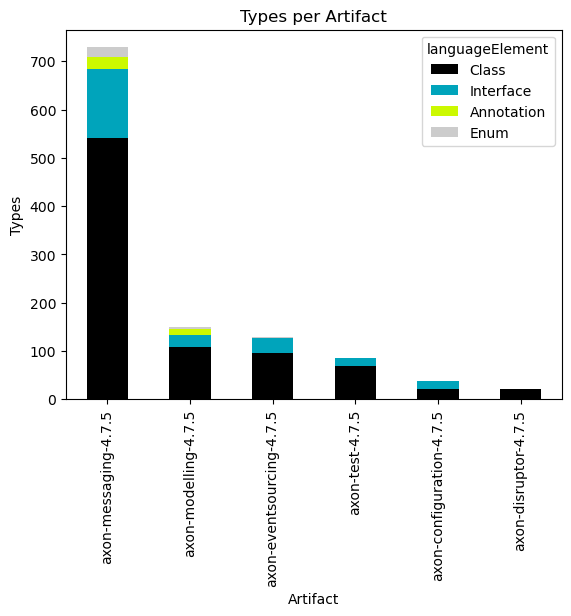

In [10]:
plot.figure();
types_per_artifact_grouped.plot(
    kind='bar', 
    title='Types per Artifact',
    xlabel='Artifact',
    ylabel='Types',
    stacked=True, 
    cmap=main_color_map
)
plot.show()

In [11]:
# (Optional) Plot "Types per Artifact" and the normalized variation side by side
# plot.figure();
# fig, (axis_left, axis_right) = plot.subplots(nrows=1, ncols=2)
# types_per_artifact_grouped.plot(
#     ax=axis_left,
#     kind='bar', 
#     title='Types per Artifact',
#     xlabel='Artifact',
#     ylabel='Types',
#     stacked=True, 
#     cmap=main_color_map
# )
# types_per_artifact_grouped_normalized.plot(
#     ax=axis_right,
#     kind='bar', 
#     title='Types per Artifact [%]',
#     xlabel='Artifact',
#     ylabel='Types %',
#     stacked=True, 
#     cmap=main_color_map
# )
# plot.show()

### Table 3 - Types per artifact (grouped and normalized in %)

In [12]:
# Divide every value by the sum of the row to get horizontal normalized values.
# This makes it easier to compare the "language element" usage without taking the size of the artifact into account
types_per_artifact_grouped_normalized = types_per_artifact_grouped.div(types_per_artifact_grouped.sum(axis=1), axis=0).multiply(100)
types_per_artifact_grouped_normalized

languageElement,Class,Interface,Annotation,Enum
artifactName,,,,
axon-messaging-4.7.5,74.211248,19.615912,3.566529,2.606310
axon-modelling-4.7.5,72.483221,17.449664,8.053691,2.013423
axon-eventsourcing-4.7.5,73.846154,23.846154,0.769231,1.538462
axon-test-4.7.5,81.176471,18.823529,0.000000,0.000000
axon-configuration-4.7.5,56.410256,38.461538,2.564103,2.564103
axon-disruptor-4.7.5,100.000000,0.000000,0.000000,0.000000


<Figure size 640x480 with 0 Axes>

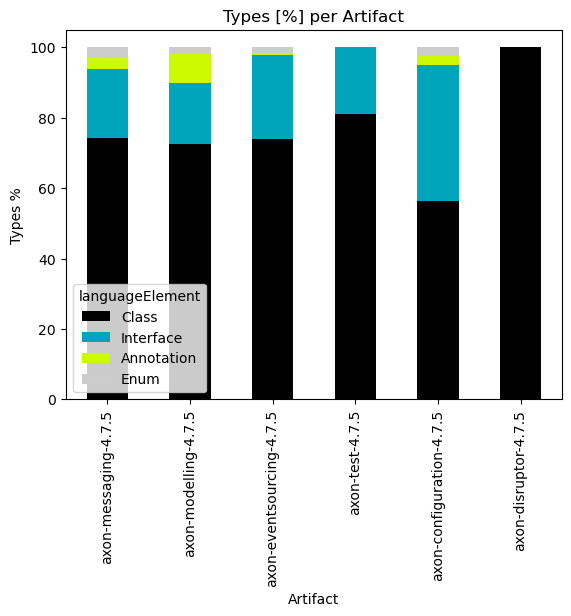

In [13]:
# Divide every value by the sum of the row to get horizontal normalized values.
# This makes it easier to compare the "language element" usage without taking the size of the artifact into account
types_per_artifact_grouped_normalized = types_per_artifact_grouped.div(types_per_artifact_grouped.sum(axis=1), axis=0).multiply(100)

plot.figure();
types_per_artifact_grouped_normalized.plot(kind='bar', stacked=True, cmap=main_color_map)
plot.xlabel('Artifact')
plot.ylabel('Types %')
plot.title('Types [%] per Artifact')
plot.show()

### Table 4 - Number of packages per artifact

In [14]:
packages_per_artifact = query_cypher_to_data_frame("../cypher/Overview/Number_of_packages_per_artifact.cypher")

# Sort the DataFrame by the sum of values
types_per_artifact_sorted = packages_per_artifact.sort_values(by='numberOfPackages', ascending=False)

# Set the name of the index to artifactName
types_per_artifact_sorted.set_index('artifactName', inplace=True)

types_per_artifact_sorted

,numberOfPackages
artifactName,
axon-messaging-4.7.5,61
axon-modelling-4.7.5,10
axon-eventsourcing-4.7.5,9
axon-test-4.7.5,8
axon-disruptor-4.7.5,1
axon-configuration-4.7.5,1


<Figure size 640x480 with 0 Axes>

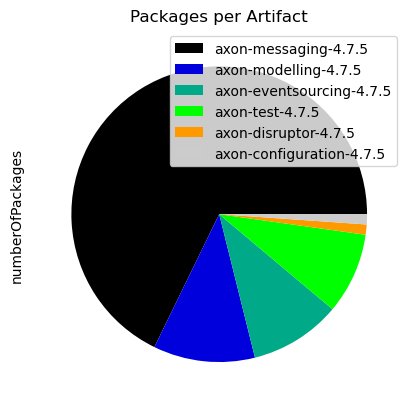

In [15]:
plot.figure();
types_per_artifact_sorted.plot(y='numberOfPackages', kind='pie', title='Packages per Artifact', labeldistance=None, cmap=main_color_map)
plot.show()

## Effective Method Line Count

### Table 5 - Effective method line count distribution

The table shown here only includes the first 10 rows which typically represents the most significant entries.
Have a look below to find out which packages and methods have the highest effective lines of code.

In [16]:
effective_method_line_count_distribution=query_cypher_to_data_frame("../cypher/Overview/Effective_Method_Line_Count_Distribution.cypher")
effective_method_line_count_distribution=effective_method_line_count_distribution.pivot(index='effectiveLineCount', columns='artifactName', values='methods')

# Fill missing values with zero
effective_method_line_count_distribution.fillna(0, inplace=True)

# Convert to integer
effective_method_line_count_distribution=effective_method_line_count_distribution.astype(int)

effective_method_line_count_distribution.head(10)

artifactName,axon-configuration-4.7.5.jar,axon-disruptor-4.7.5.jar,axon-eventsourcing-4.7.5.jar,axon-messaging-4.7.5.jar,axon-modelling-4.7.5.jar,axon-test-4.7.5.jar
effectiveLineCount,,,,,,
1,304,81,567,2493,471,234
2,135,30,197,726,134,144
3,33,30,123,558,129,52
4,33,7,64,246,54,41
5,14,4,40,197,43,20
6,16,6,33,133,36,12
7,2,2,31,93,23,18
8,9,0,11,73,9,10
9,8,3,17,65,7,9


### Table 6 - Effective method line count distribution (normalized)

The table shown here only includes the first 10 rows which typically represents the most significant entries.
Have a look below to find out which packages and methods have the highest effective lines of code.

In [17]:
# Divide every value by the sum of all values in the same column to get vertical normalized values.
effective_method_line_count_distribution_normalized = effective_method_line_count_distribution.div(effective_method_line_count_distribution.sum(axis=0), axis=1).multiply(100)
effective_method_line_count_distribution_normalized.head(10)

artifactName,axon-configuration-4.7.5.jar,axon-disruptor-4.7.5.jar,axon-eventsourcing-4.7.5.jar,axon-messaging-4.7.5.jar,axon-modelling-4.7.5.jar,axon-test-4.7.5.jar
effectiveLineCount,,,,,,
1,52.961672,46.022727,50.489760,51.937500,49.631191,40.554593
2,23.519164,17.045455,17.542297,15.125000,14.120126,24.956672
3,5.749129,17.045455,10.952805,11.625000,13.593256,9.012132
4,5.749129,3.977273,5.699020,5.125000,5.690200,7.105719
5,2.439024,2.272727,3.561888,4.104167,4.531085,3.466205
6,2.787456,3.409091,2.938557,2.770833,3.793467,2.079723
7,0.348432,1.136364,2.760463,1.937500,2.423604,3.119584
8,1.567944,0.000000,0.979519,1.520833,0.948367,1.733102
9,1.393728,1.704545,1.513802,1.354167,0.737619,1.559792


<Figure size 640x480 with 0 Axes>

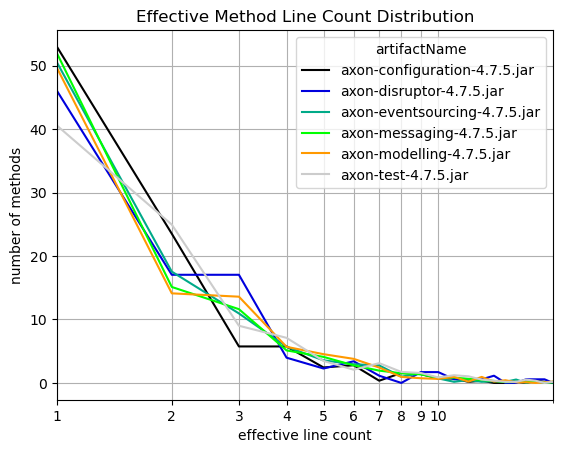

In [18]:
plot.figure();
method_line_count_x_ticks=range(1,11)
axes = effective_method_line_count_distribution_normalized.plot(
    kind='line', 
    logx=True,
    grid=True,
    xlim=[1,20],
    xticks=method_line_count_x_ticks,
    title='Effective Method Line Count Distribution', 
    xlabel='effective line count',
    ylabel='number of methods',
    cmap=main_color_map,
)
axes.set_xticklabels(method_line_count_x_ticks)
plot.show()

### Table 7 - Cyclomatic method complexity distribution

The table shown here only includes the first 10 rows which typically represents the most significant entries.
Have a look below to find out which packages and methods have the highest effective lines of code.

In [19]:
cyclomatic_method_complexity_distribution=query_cypher_to_data_frame("../cypher/Overview/Cyclomatic_Method_Complexity_Distribution.cypher")
cyclomatic_method_complexity_distribution=cyclomatic_method_complexity_distribution.pivot(index='cyclomaticComplexity', columns='artifactName', values='methods')

# Fill missing values with zero
cyclomatic_method_complexity_distribution.fillna(0, inplace=True)

# Convert to integer
cyclomatic_method_complexity_distribution=cyclomatic_method_complexity_distribution.astype(int)

cyclomatic_method_complexity_distribution.head(10)

artifactName,axon-configuration-4.7.5.jar,axon-disruptor-4.7.5.jar,axon-eventsourcing-4.7.5.jar,axon-messaging-4.7.5.jar,axon-modelling-4.7.5.jar,axon-test-4.7.5.jar
cyclomaticComplexity,,,,,,
1,515,143,926,3831,786,428
2,37,18,92,409,71,55
3,13,4,54,266,34,44
4,3,4,24,129,24,21
5,3,2,9,65,18,11
6,1,2,3,43,10,7
7,2,1,7,19,2,4
8,0,2,7,9,1,3
9,0,0,0,7,2,1


### Table 8 - Cyclomatic method complexity distribution (normalized)

The table shown here only includes the first 10 rows which typically represents the most significant entries.
Have a look below to find out which packages and methods have the highest effective lines of code.

In [20]:
# Divide every value by the sum of all values in the same column to get vertical normalized values.
cyclomatic_method_complexity_distribution_normalized = cyclomatic_method_complexity_distribution.div(cyclomatic_method_complexity_distribution.sum(axis=0), axis=1).multiply(100)
cyclomatic_method_complexity_distribution_normalized.head(10)

artifactName,axon-configuration-4.7.5.jar,axon-disruptor-4.7.5.jar,axon-eventsourcing-4.7.5.jar,axon-messaging-4.7.5.jar,axon-modelling-4.7.5.jar,axon-test-4.7.5.jar
cyclomaticComplexity,,,,,,
1,89.721254,81.250000,82.457703,79.812500,82.824025,74.176776
2,6.445993,10.227273,8.192342,8.520833,7.481560,9.532062
3,2.264808,2.272727,4.808549,5.541667,3.582719,7.625650
4,0.522648,2.272727,2.137133,2.687500,2.528978,3.639515
5,0.522648,1.136364,0.801425,1.354167,1.896733,1.906412
6,0.174216,1.136364,0.267142,0.895833,1.053741,1.213172
7,0.348432,0.568182,0.623330,0.395833,0.210748,0.693241
8,0.000000,1.136364,0.623330,0.187500,0.105374,0.519931
9,0.000000,0.000000,0.000000,0.145833,0.210748,0.173310


<Figure size 640x480 with 0 Axes>

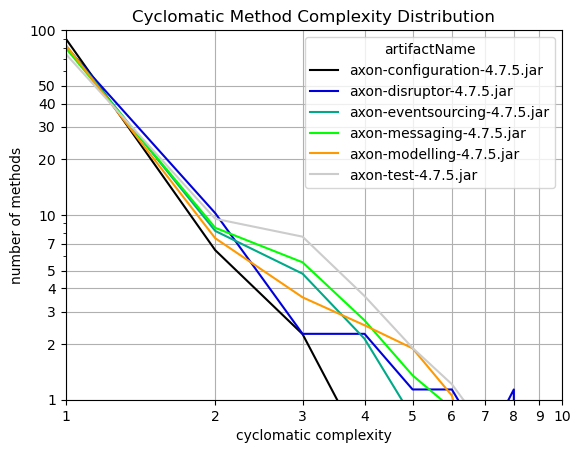

In [21]:
plot.figure();
method_line_count_x_ticks=range(1,11)
cyclomatic_complexity_y_ticks=[1, 2, 3, 4, 5, 7, 10, 20, 30, 40, 50, 100]
axes = cyclomatic_method_complexity_distribution_normalized.plot(
    kind='line', 
    logx=True,
    logy=True,
    grid=True,
    xlim=[1,10],
    ylim=[1,100],
    xticks=method_line_count_x_ticks,
    yticks=cyclomatic_complexity_y_ticks,
    title='Cyclomatic Method Complexity Distribution', 
    xlabel='cyclomatic complexity',
    ylabel='number of methods',
    cmap=main_color_map,
)
axes.set_xticklabels(method_line_count_x_ticks)
axes.set_yticklabels(cyclomatic_complexity_y_ticks)
plot.show()

### Table 9 - Top 10 packages with highest effective line counts

In [22]:
# Query data from graph database
effective_line_count_per_package = query_cypher_to_data_frame("../cypher/Overview/Effective_lines_of_method_code_per_package.cypher")

# Select columns and top 10 rows (head)
effective_line_count_per_package[['artifactName', 'fullPackageName', 'linesInPackage', 'methodCount', 'maxLinesMethod','maxLinesMethodName']].head(10)

,artifactName,fullPackageName,linesInPackage,methodCount,maxLinesMethod,maxLinesMethodName
0,axon-messaging-4.7.5,org.axonframework.eventhandling,2175,776,64,processBatch
1,axon-configuration-4.7.5,org.axonframework.config,1474,574,42,<init>
2,axon-messaging-4.7.5,org.axonframework.eventhandling.pooled,939,308,70,run
3,axon-messaging-4.7.5,org.axonframework.queryhandling,832,333,36,doQuery
4,axon-eventsourcing-4.7.5,org.axonframework.eventsourcing.eventstore,709,262,21,peekPrivateStream
5,axon-modelling-4.7.5,org.axonframework.modelling.command,702,286,13,doLoadWithLock
6,axon-messaging-4.7.5,org.axonframework.messaging.annotation,673,239,23,<init>
7,axon-test-4.7.5,org.axonframework.test.aggregate,633,170,45,appendEventOverview
8,axon-eventsourcing-4.7.5,org.axonframework.eventsourcing,582,236,20,doScheduleSnapshot
9,axon-eventsourcing-4.7.5,org.axonframework.eventsourcing.eventstore.leg...,570,185,25,fetchTrackedEvents


### Table 10 - Top 10 methods with highest effective line counts

In [23]:
# Sort by maxLinesMethod
effective_line_count_per_method=effective_line_count_per_package.sort_values(by='maxLinesMethod', ascending=False)

# Reset index
effective_line_count_per_method = effective_line_count_per_method.reset_index()

# Select columns and top 10 rows (head)
effective_line_count_per_method[['artifactName', 'fullPackageName', 'maxLinesMethodType', 'maxLinesMethodName', 'maxLinesMethod']].head(10)

,artifactName,fullPackageName,maxLinesMethodType,maxLinesMethodName,maxLinesMethod
0,axon-messaging-4.7.5,org.axonframework.eventhandling.pooled,Coordinator$CoordinationTask,run,70
1,axon-messaging-4.7.5,org.axonframework.eventhandling,TrackingEventProcessor,processBatch,64
2,axon-messaging-4.7.5,org.axonframework.commandhandling.gateway,CommandGatewayFactory,createGateway,50
3,axon-test-4.7.5,org.axonframework.test.aggregate,Reporter,appendEventOverview,45
4,axon-configuration-4.7.5,org.axonframework.config,EventProcessingModule,<init>,42
5,axon-messaging-4.7.5,org.axonframework.deadline.quartz,DeadlineJob,execute,42
6,axon-modelling-4.7.5,org.axonframework.modelling.saga.repository.jdbc,JdbcSagaStore,updateSaga,38
7,axon-messaging-4.7.5,org.axonframework.queryhandling,SimpleQueryBus,doQuery,36
8,axon-messaging-4.7.5,org.axonframework.messaging.deadletter,InMemorySequencedDeadLetterQueue,process,33
9,axon-messaging-4.7.5,org.axonframework.messaging.unitofwork,BatchingUnitOfWork,executeWithResult,32


### Table 11 - Top 10 methods with highest cyclomatic complexity

In [24]:
# Sort by maxComplexity
cyclomatic_complexity_per_method=effective_line_count_per_package.sort_values(by='maxComplexity', ascending=False)

# Reset Index
cyclomatic_complexity_per_method = cyclomatic_complexity_per_method.reset_index()

# Select columns and only the top 10 rows (head)
cyclomatic_complexity_per_method[['artifactName', 'fullPackageName', 'maxComplexityType', 'maxComplexityMethod', 'maxComplexity']].head(10)

,artifactName,fullPackageName,maxComplexityType,maxComplexityMethod,maxComplexity
0,axon-messaging-4.7.5,org.axonframework.eventhandling.scheduling.job...,JobRunrEventScheduler,$deserializeLambda$,40
1,axon-messaging-4.7.5,org.axonframework.eventhandling,TrackingEventProcessor,processBatch,21
2,axon-messaging-4.7.5,org.axonframework.eventhandling.pooled,Coordinator$CoordinationTask,run,21
3,axon-modelling-4.7.5,org.axonframework.modelling.saga.repository,AssociationValueMap$AssociationValueComparator,compare,16
4,axon-messaging-4.7.5,org.axonframework.eventhandling.deadletter.jpa,DeadLetterEventEntry,equals,15
5,axon-messaging-4.7.5,org.axonframework.messaging.annotation,AnnotatedMessageHandlingMember,handle,14
6,axon-messaging-4.7.5,org.axonframework.commandhandling.distributed....,CommandNameFilter,$deserializeLambda$,13
7,axon-messaging-4.7.5,org.axonframework.deadline.jobrunr,JobRunrDeadlineManager,$deserializeLambda$,13
8,axon-eventsourcing-4.7.5,org.axonframework.eventsourcing.eventstore,ConcatenatingDomainEventStream,hasNext,13
9,axon-messaging-4.7.5,org.axonframework.common.jdbc,ConnectionWrapperFactory,lambda$wrap$0,12
